# Example: div-k-grad-u inverse problem
# WORK IN PROGRESS, DO NOT USE

In [1]:
import numpy as np
from fenics import *
import matplotlib.pyplot as plt
from ufl import replace

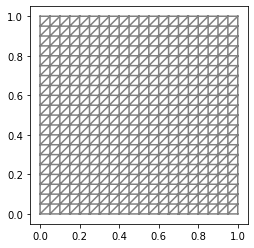

In [2]:
mesh_n = 20
mesh = UnitSquareMesh(mesh_n, mesh_n)
V = FunctionSpace(mesh, 'CG', 1)
plot(mesh)

For the forward problem, we use the inhomogeneous Poisson problem with Dirichlet boundary conditions:
$$\begin{cases}
-\nabla \cdot e^m \nabla u = f & \text{in } \Omega \\
u = 0 & \text{on } \partial \Omega,
\end{cases}$$
where the domain is the unit square, $\Omega=[0,1]^2$, $n$ is the normal to $\partial \Omega$, the parameter is 
$$m(x) = 1.25 + \sin\left(10\|x\|\right),$$
and the source is
$$m(x) = \exp\left(-\frac{\left\|x - p_1\right\|^2}{\sigma^2}\right) + \exp\left(-\frac{\left\|x - p_2\right\|^2}{\sigma^2}\right)$$
where $p_1 = (0.75,0.75)$, $p_2 = (0.25, 0.1)$, $\sigma = 0.1$$.

The weak form for this problem may be written as seeking $u \in H^1_0(\Omega)$ which satisfies
$$0 = g(m,u,v) := \int_\Omega \nabla v \cdot e^m \nabla u dx - \int_\Omega f v dx$$
for all $v \in H^1_0(\Omega)$.

In [3]:
u = Function(V)
v = Function(V)
m = Function(V)

m_true = Expression('1.25 + sin(10*sqrt(pow(x[0],2) + pow(x[1],2)))', degree=5)

f1 = Expression('exp(- (pow(x[0]-a,2) + pow(x[1]-b,2))/s)', a=0.5, b=0.5, s=0.02, degree=5)
# f2 = Expression('exp(- (pow(x[0]-a,2) + pow(x[1]-b,2))/s)', a=0.1, b=0.1, s=0.02, degree=5)
# f = f1 + f2
f = f1

m_true_vector = project(m_true, V).vector()
m.vector()[:] = m_true_vector[:].copy()

Text(0.5, 1.0, 'true parameter m')

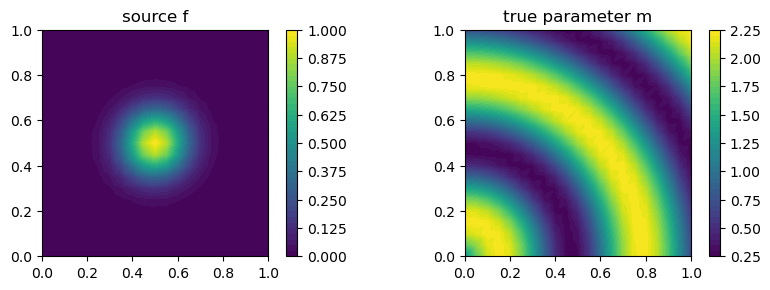

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3), dpi= 100)
plt.sca(axs[0])
cm = plot(f, mesh=mesh)
plt.colorbar(cm)
plt.title('source f')

plt.sca(axs[1])
cm = plot(m_true, mesh=mesh)
plt.colorbar(cm)
plt.title('true parameter m')

In [5]:
forward_form_base = (inner(exp(m) * grad(u), grad(v))*dx) - (f * v * dx)

forward_form0 = replace(forward_form_base, {v:TestFunction(V)})

forward_form = replace(forward_form_base, {u:TrialFunction(V), v:TestFunction(V)})
forward_lhs = lhs(forward_form)
forward_rhs = rhs(forward_form)

def the_boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant(0.0), the_boundary)

G = assemble(forward_lhs)
bc.apply(G)
G_solver = LUSolver(G)

def solve_forward():
    b = assemble(forward_rhs)
    bc.apply(b)
    G_solver.solve(u.vector(), b)
    
solve_forward()

Text(0.5, 1.0, 'true u')

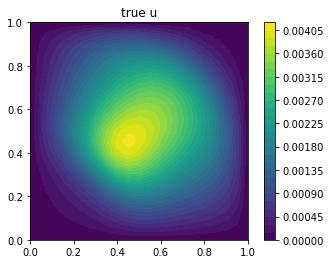

In [6]:
cm = plot(u)
plt.colorbar(cm)
plt.title('true u')

The data misfit function is
$$J_d(m) := \int_{\partial \Omega} \left(\nu \cdot e^m\nabla u(m) - \nu \cdot e^m \nabla u_\text{true}\right)^2 ds.$$

In [7]:
u_true = Function(V)
u_true.vector()[:] = u.vector()[:].copy()

nu = FacetNormal(mesh)

Jd_form = pow(inner(nu, exp(m) * grad(u - u_true)), 2) * ds

def compute_data_misfit():
    return assemble(Jd_form)

Jd_true = compute_data_misfit()
print('Jd_true=', Jd_true)

Jd_true= 0.0


In [8]:
def update_m(new_m_vector):
    global G 
    global G_solver
    m.vector()[:] = new_m_vector[:].copy()
    G = assemble(forward_lhs)
    bc.apply(G)
    G_solver = LUSolver(G)

In [9]:
zero_vector = Function(V).vector()

update_m(zero_vector)
solve_forward()
Jd_0 = compute_data_misfit()

print('Jd_0=', Jd_0)

Jd_0= 0.0005339860257976057


Text(0.5, 1.0, 'u at m=0')

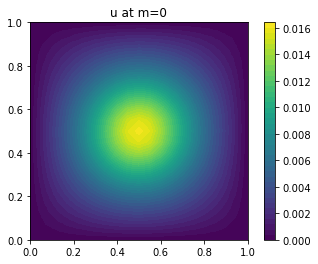

In [10]:
cm1 = plot(u)
plt.colorbar(cm1)
plt.title('u at m=0')

The Lagrangian is
$$\mathcal{L}(m,u,v) := J(m,u,v) + g(m,u,v).$$
We seek an the adjoint variable $v \in H^1_0(\Omega)$ that solves the following adjoint equation
$$0 = a(m,u,v,\widetilde{u}) := \frac{\partial \mathcal{L}}{\partial u}(m,u,v,\widetilde{u}) = 0$$
for all $\widetilde{u} \in H^1_0(\Omega)$.

In [11]:
lagrangian_form = Jd_form + forward_form_base

adjoint_form0 = derivative(lagrangian_form, u, TestFunction(V))

adjoint_form = replace(adjoint_form0, {v:TrialFunction(V)})
adjoint_lhs = lhs(adjoint_form)
adjoint_rhs = rhs(adjoint_form)

def solve_adjoint():
    b = assemble(adjoint_rhs)
    bc.apply(b)
#     G_solver.solve_transpose(v.vector(), b)
    G_solver.solve(v.vector(), b) # symmetric

solve_adjoint()

In [12]:
[print(a) for a in adjoint_form.arguments()]

v_0
v_1


[None, None]

Text(0.5, 1.0, 'adjoint v')

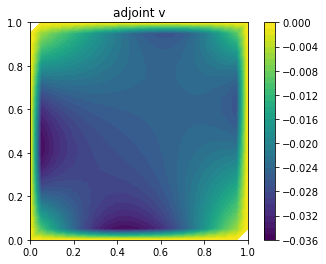

In [13]:
cm = plot(v)
plt.colorbar(cm)
plt.title('adjoint v')

The gradient dual function is given by 
$$g(h) = \frac{\partial \mathcal{L}}{\partial m}(m,u,v)h.$$
The Riesz representative of the gradient is given by the function $g_\text{Riesz}$ satisfying
$$\int_\Omega h g_\text{Riesz} dx = g(h)$$
for all $v$.

In [14]:
mass_form = TrialFunction(V) * TestFunction(V) * dx
M = assemble(mass_form)

M_solver = LUSolver(M)

In [15]:
gradient_form0 = derivative(lagrangian_form, m, TestFunction(V))

def compute_gradient(return_riesz_representative=False):
    g_dual_vector = assemble(gradient_form0)
    
    if return_riesz_representative:
        g_riesz_representative = Function(V)
        M_solver.solve(g_riesz_representative.vector(), g_dual_vector)
        return g_dual_vector, g_riesz_representative
    else:
        return g_dual_vector

g_dual0, g_riesz0 = compute_gradient(return_riesz_representative=True)

Text(0.5, 1.0, 'gradient (riesz representative)')

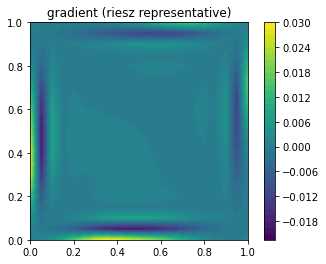

In [16]:
cm = plot(g_riesz0)
plt.colorbar(cm)
plt.title('gradient (riesz representative)')

In [17]:
m_original_numpy_vector = m.vector()[:].copy()

s = 1e-6
dm = Function(V)
dm.vector()[:] = np.random.randn(V.dim()) # perturb m a small bit

update_m(m_original_numpy_vector + s * dm.vector()[:])

solve_forward()
Jd_1 = compute_data_misfit()
solve_adjoint()
g_dual1, g_riesz1 = compute_gradient(return_riesz_representative=True)


update_m(m_original_numpy_vector) # Reset to original m

In [18]:
dJ_diff = (Jd_1 - Jd_0)/s

dJ = np.dot(g_dual0[:], dm.vector()[:])

err_grad = (dJ - dJ_diff)/dJ_diff
print('s=', s, ', err_grad=', err_grad)

s= 1e-06 , err_grad= -1.4001954460611576e-06


# Hessian vector products

In [19]:
p = Function(V) # Function to apply the Hessian to (p -> Hp)
icru = Function(V) # incremental state
icrv = Function(V) # incremental adjoint

# Hessian vector product is directional derivative of gradient
hessian_form0 = (derivative(gradient_form0, m, p)
                + derivative(gradient_form0, u, icru)
                + derivative(gradient_form0, v, icrv))

# Incremental forward equation is total derivative of forward equation
incremental_forward_form0 = (derivative(forward_form0, m, p) 
                             + derivative(forward_form0, u, icru))

incremental_forward_form = replace(incremental_forward_form0, {icru:TrialFunction(V)})
incremental_forward_rhs = rhs(incremental_forward_form)

# Incremental adjoint equation is total derivative of adjoint equation
incremental_adjoint_form0 = (derivative(adjoint_form0, m, p) 
                             + derivative(adjoint_form0, u, icru) 
                             + derivative(adjoint_form0, v, icrv))

incremental_adjoint_form = replace(incremental_adjoint_form0, {icrv:TrialFunction(V)})
incremental_adjoint_rhs = rhs(incremental_adjoint_form)

In [20]:
def solve_incremental_forward():
    b = assemble(incremental_forward_rhs)
    bc.apply(b)
    G_solver.solve(icru.vector(), b)

In [21]:
def solve_incremental_adjoint():
    b = assemble(incremental_adjoint_rhs)
    bc.apply(b)
#     G_solver.solve_transpose(v.vector(), b)
    G_solver.solve(icrv.vector(), b) # symmetric

In [22]:
def compute_hessian_vector_product(p_vector):
    p.vector()[:] = p_vector[:].copy()
    
    solve_incremental_forward()
    solve_incremental_adjoint()
    Hp = assemble(hessian_form0)
    return Hp

In [23]:
update_m(m_original_numpy_vector) # Reset to original m

solve_forward()
solve_adjoint()
Hdm = compute_hessian_vector_product(dm.vector()[:].copy())

In [24]:
Hdm_diff = (g_dual1[:] - g_dual0[:])/s
err_hess = np.linalg.norm(Hdm_diff - Hdm[:])/np.linalg.norm(Hdm_diff)
print('s=', s, ', err_hess=', err_hess)

s= 1e-06 , err_hess= 7.156387751632158e-07
